In [13]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import matplotlib

In [2]:
from plotting.plot_funcs import save_figure

In [3]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"

In [4]:
neurons = sc.read("../data/h5ad/neuronal-final.h5ad")

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [5]:
aggr = sc.read("../../final_analysis/aggr_output_ver5/posterior_hypothalamus_aggr-aggr_20190821.h5ad")

In [6]:
neurons_raw = aggr[neurons.obs_names].copy()
_, raw_var = sc.pp.calculate_qc_metrics(neurons_raw, percent_top=None)

In [7]:
from itertools import chain
def get_top_k_genes(adata, k=10, groupby="cluster_revised"):
    tmp = adata.copy()
    sc.tl.rank_genes_groups(
        tmp, method="wilcoxon", groupby=groupby,use_raw=False, 
        n_genes=k, key_added="feature_selection"
    )
    return list(set(chain.from_iterable(tmp.uns["feature_selection"]["names"])))

In [8]:
raw_var.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
index,,,,,,
Xkr4,2264,0.347055,0.297921,75.666380,3229.0,8.080237
Rp1,2,0.000215,0.000215,99.978504,2.0,1.098612
Sox17,31,0.003332,0.003326,99.666810,31.0,3.465736
Mrpl15,4880,0.995163,0.690726,47.549441,9259.0,9.133459
Lypla1,2655,0.371346,0.315793,71.463887,3455.0,8.147867


In [9]:
neurons.var[raw_var.columns] = raw_var

In [10]:
all_genes = neurons.var["total_counts"].values
hv_genes = neurons.var.loc[neurons.var.highly_variable, "total_counts"].values
topk = get_top_k_genes(neurons, k=10)
topk_genes = neurons.var.loc[topk, "total_counts"].values

In [11]:
mito_genes = neurons.var.loc[neurons.var.mitochondrial, "total_counts"].values
ribo_genes = neurons.var.loc[neurons.var.ribosomal, "total_counts"].values
cc_genes = neurons.var.loc[neurons.var.cell_cycle, "total_counts"].values

Saved to umis_per_gene_histogram-with-bottoms.pdf


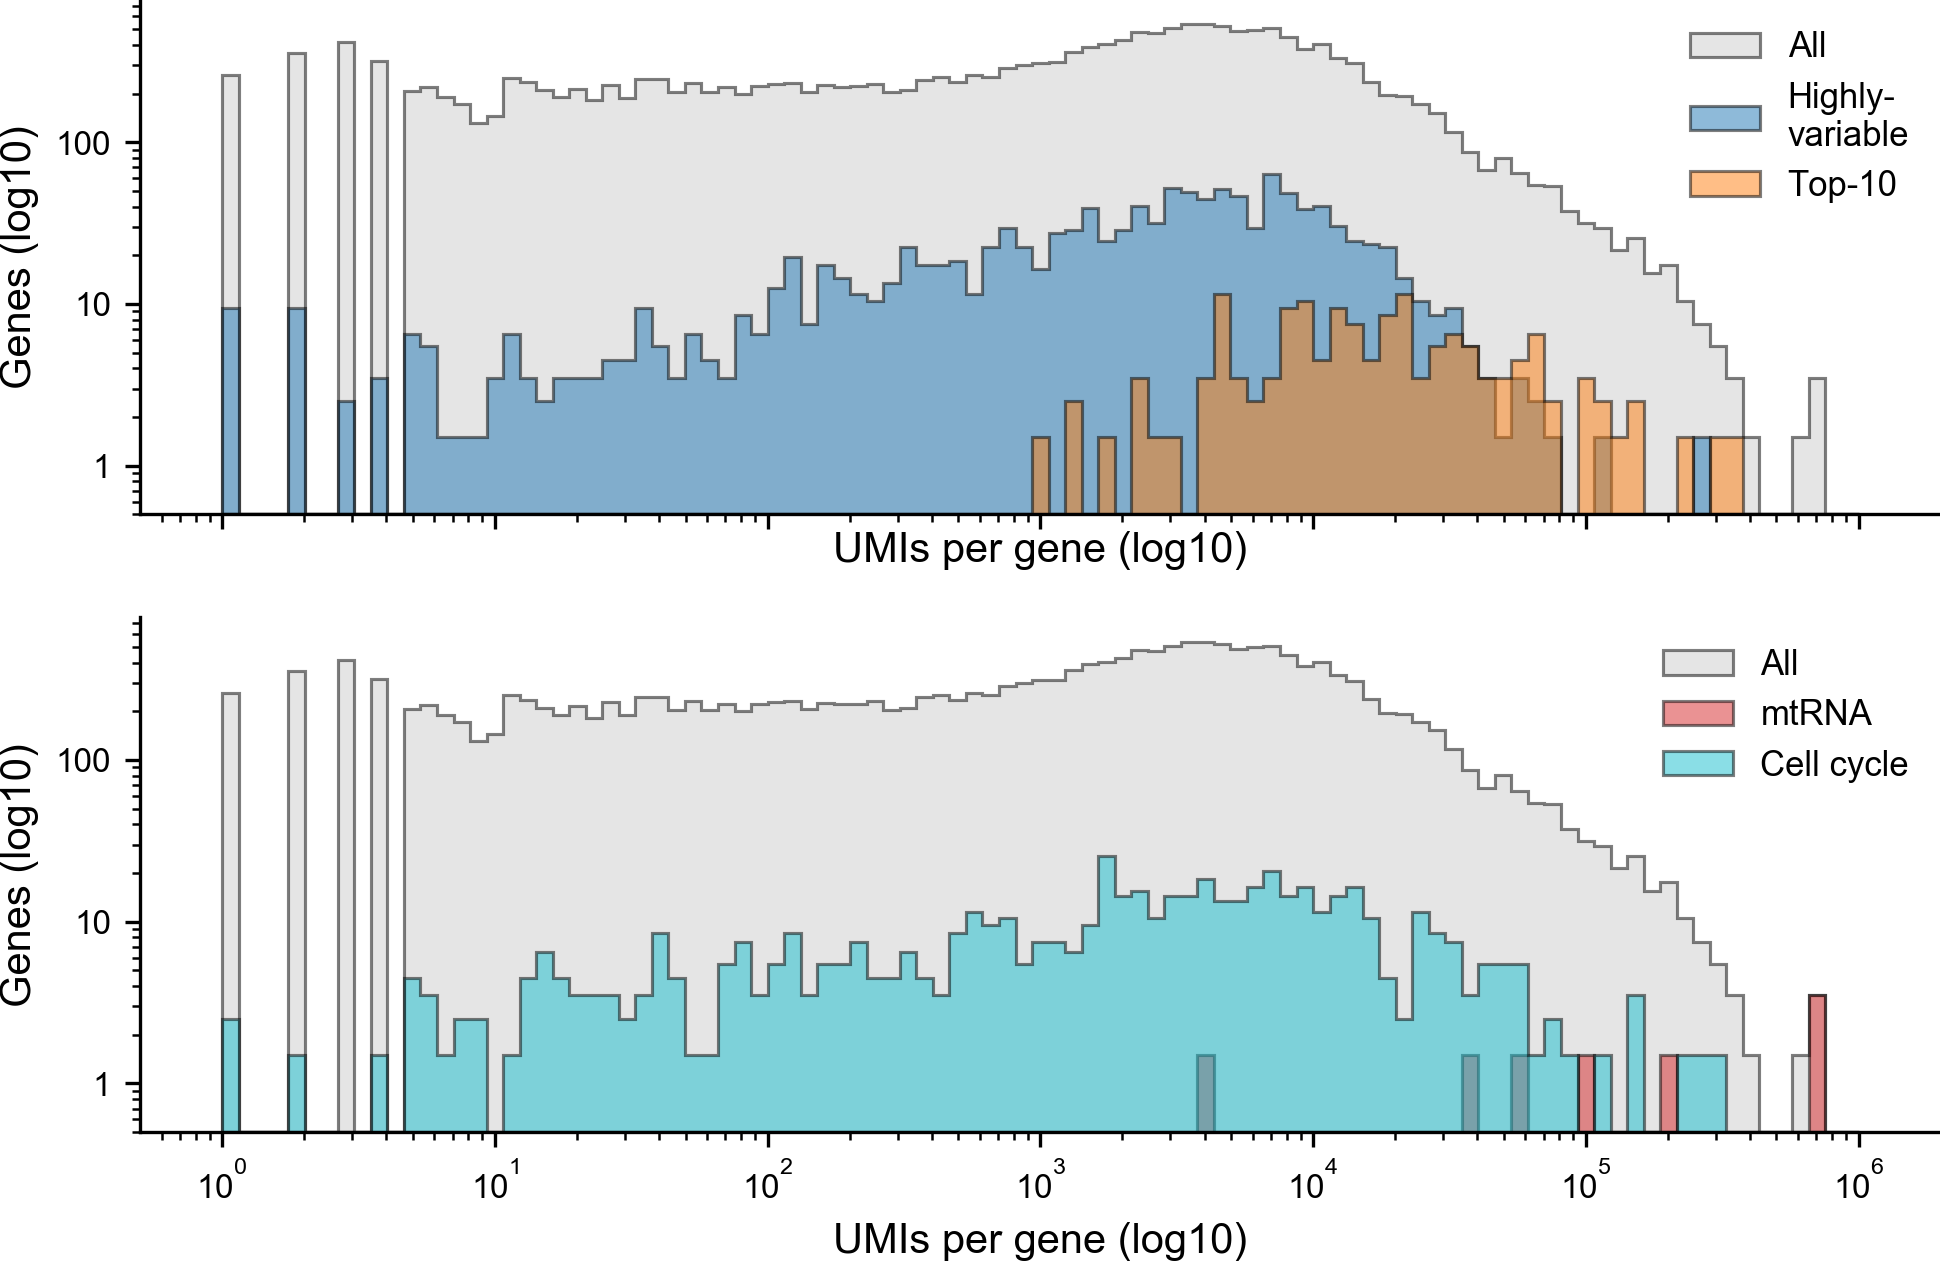

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), dpi=300, sharex=True, sharey=True)
bins = np.logspace(0, 6, 100)
params = dict(bins=bins, alpha=0.5, histtype="stepfilled", lw=0.75, bottom=0.5, edgecolor="k", log=True)
ax1.hist(all_genes, color="0.8", label="All", **params)
ax1.hist(hv_genes, label="Highly-\nvariable", **params)
ax1.hist(topk_genes, label="Top-10", **params)

ax2.hist(all_genes, color="0.8", label="All", **params)
ax2.hist(mito_genes, color="C3", label="mtRNA", **params)
ax2.hist(cc_genes, color="C9", label="Cell cycle", **params)


for ax in (ax1, ax2):
    ax.set_xscale("log")
    ax.set_yscale("log") 
    ax.set_ylabel("Genes (log10)")
    ax.set_xlabel("UMIs per gene (log10)")
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.legend(loc="upper right", frameon=False, fontsize="small")#True, edgecolor="k", fancybox=False)
seaborn.despine(fig,)
fig.subplots_adjust(wspace=0.05)

save_figure(fig, "data-quality", "umis_per_gene_histogram-with-bottoms")

# UMIs/cell for select genes

Saved to umis_per_cell_histograms.pdf


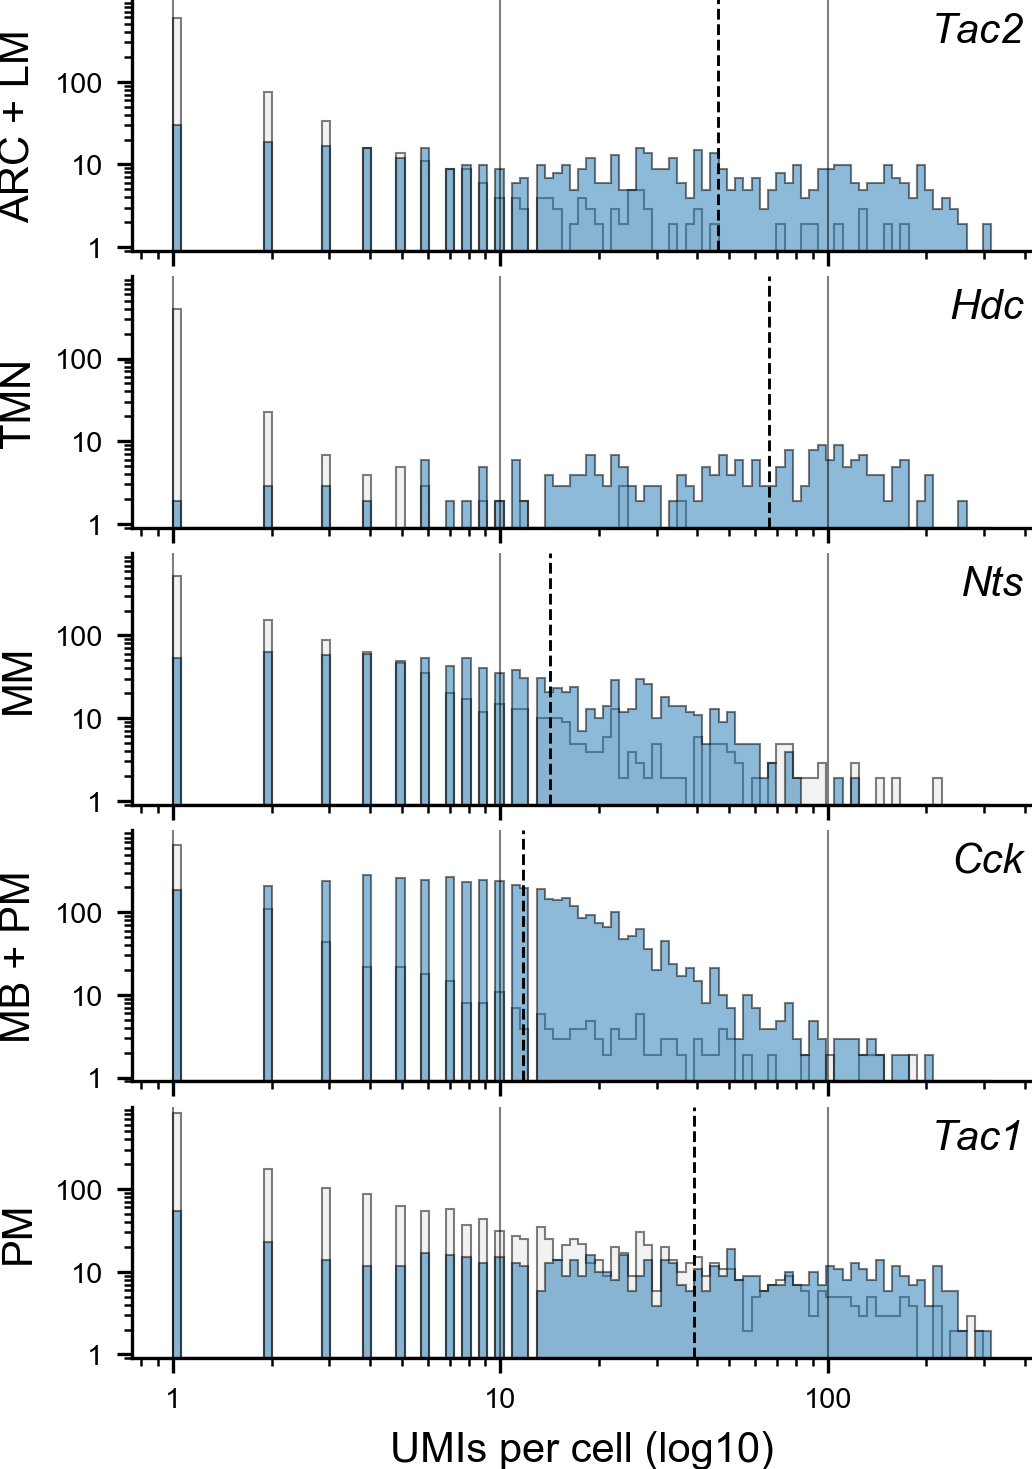

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(3, 6), sharex=True, sharey=True, dpi=300, gridspec_kw=dict(hspace=0.1))

hist_genes = ["Tac2", "Hdc", "Nts", "Cck", "Tac1",]
hist_clusters = [["5", "16", "20"], ["17"], ["1"], list("123456"), ["7"], ]
hist_names = ["ARC + LM", "TMN", "MM", "MB + PM", "PM", ]

bins = np.logspace(0, 2.5, 100)
params = dict(bins=bins, alpha=0.5, histtype="stepfilled", lw=0.5, bottom=0.9, log=True, edgecolor="k")

for ax, gene, cluster, name in zip(axs.flat, hist_genes, hist_clusters, hist_names):
    ind = neurons.obs.cluster_revised.isin(cluster)

    m = np.mean(neurons_raw[ind, :][:, gene].X.todense().tolist())
    ax.axvline(x=m, color="k", ls="--", lw=0.7)
    ax.hist(neurons_raw[~ind, :][:, gene].X.todense(), color="0.9", **params)
    ax.hist(neurons_raw[ind, :][:, gene].X.todense(), color="C0", **params)

    
    ax.set_ylabel(name)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(0.9, 999)
    #ax.set_yticks([10, 100, 1000])
    ax.text(
        0.99, 0.95, gene, 
        fontdict={"style":"italic"}, ha="right", va="top", 
        bbox=dict(facecolor="w", edgecolor="none"), transform=ax.transAxes
    )
    ax.grid(axis="x", which="major", ls="-", color="k", zorder=-10, linewidth=0.5, alpha=0.5)
    ax.tick_params(axis="both", labelsize="x-small")
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[-1].set_xlabel("UMIs per cell (log10)")

seaborn.despine(fig)
save_figure(fig, "data-quality", "umis_per_cell_histograms")

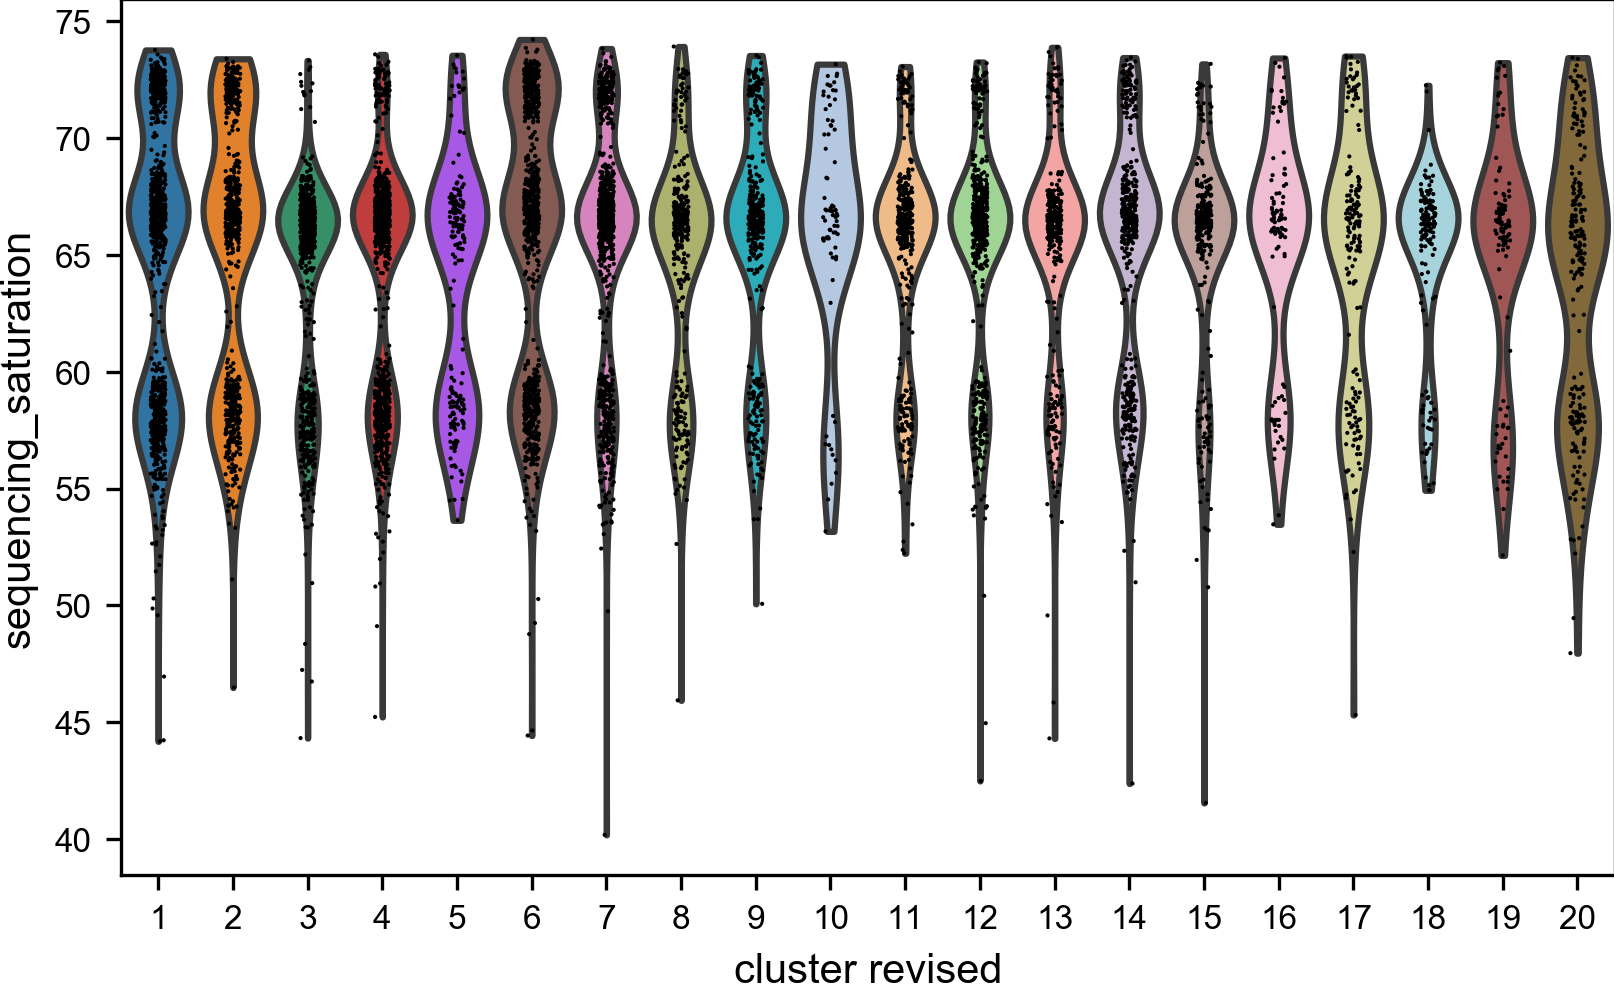

In [116]:
sc.pl.violin(neurons, "sequencing_saturation", groupby="cluster_revised")

# Mixture model stuff

In [204]:
from sklearn.mixture import GaussianMixture

In [207]:
assert pd.Index(("Snap25", "Syp", "Tubb3", "Elavl2")).isin(aggr.var_names).all()

mixture = GaussianMixture(n_components=2)
mixture.fit(aggr[:, ["Snap25", "Syp", "Tubb3", "Elavl2"]].X.toarray())
x = mixture.predict(aggr[:, ["Snap25", "Syp", "Tubb3", "Elavl2"]].X.toarray())
aggr.obs["classification_int"] = x

In [256]:
a, b = mixture.sample(1000)

Text(0.5, 0, 'Expression level')

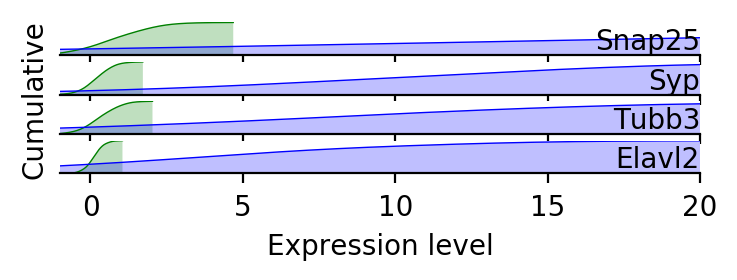

In [308]:
fig, axs = plt.subplots(4, 1, figsize=(4, 1), sharex=True)
colors = ["green", "blue"]
genes = ["Snap25", "Syp", "Tubb3", "Elavl2"]
for n in range(4):
    for k in range(2):
        seaborn.kdeplot(a[b==k,n], shade=True, lw=0.5, cumulative=True, cut=0, ax=axs[n], color=colors[k])
    axs[n].text(1, 0., genes[n], ha="right", va="bottom", transform=axs[n].transAxes)

seaborn.despine(fig, left=True)
for ax in axs:
    ax.set_yticks([])
    ax.set_xlim(-1, 20)
    ax.set_ylim(0, 1)
fig.subplots_adjust(left=0.1)
fig.text(0.05, 0.5, "Cumulative", rotation=90, va="center")
axs[-1].set_xlabel("Expression level")

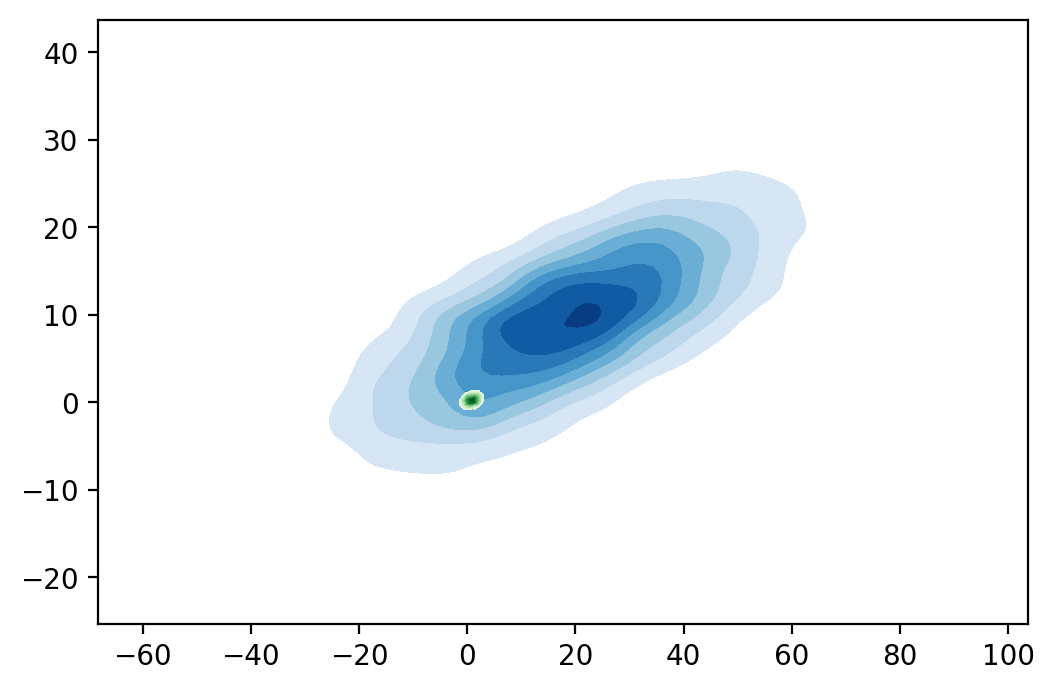

In [229]:
seaborn.kdeplot(a[b==1,0], a[b==1,1], shade=True, shade_lowest=False, cmap="Blues")
seaborn.kdeplot(a[b==0,0], a[b==0,1], shade=True, shade_lowest=False, cmap="Greens")

In [258]:
mix_data = pd.DataFrame(
    np.column_stack((a, -1*b)),
    columns=["Snap25", "Syp", "Tubb3", "Elavl2", "Class"]
)
mix_data["Class"] = mix_data["Class"].map({-1: "Neuron", 0: "Non-neuron"})

In [299]:
list(zip(*np.tril_indices(4, -1)))

[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]

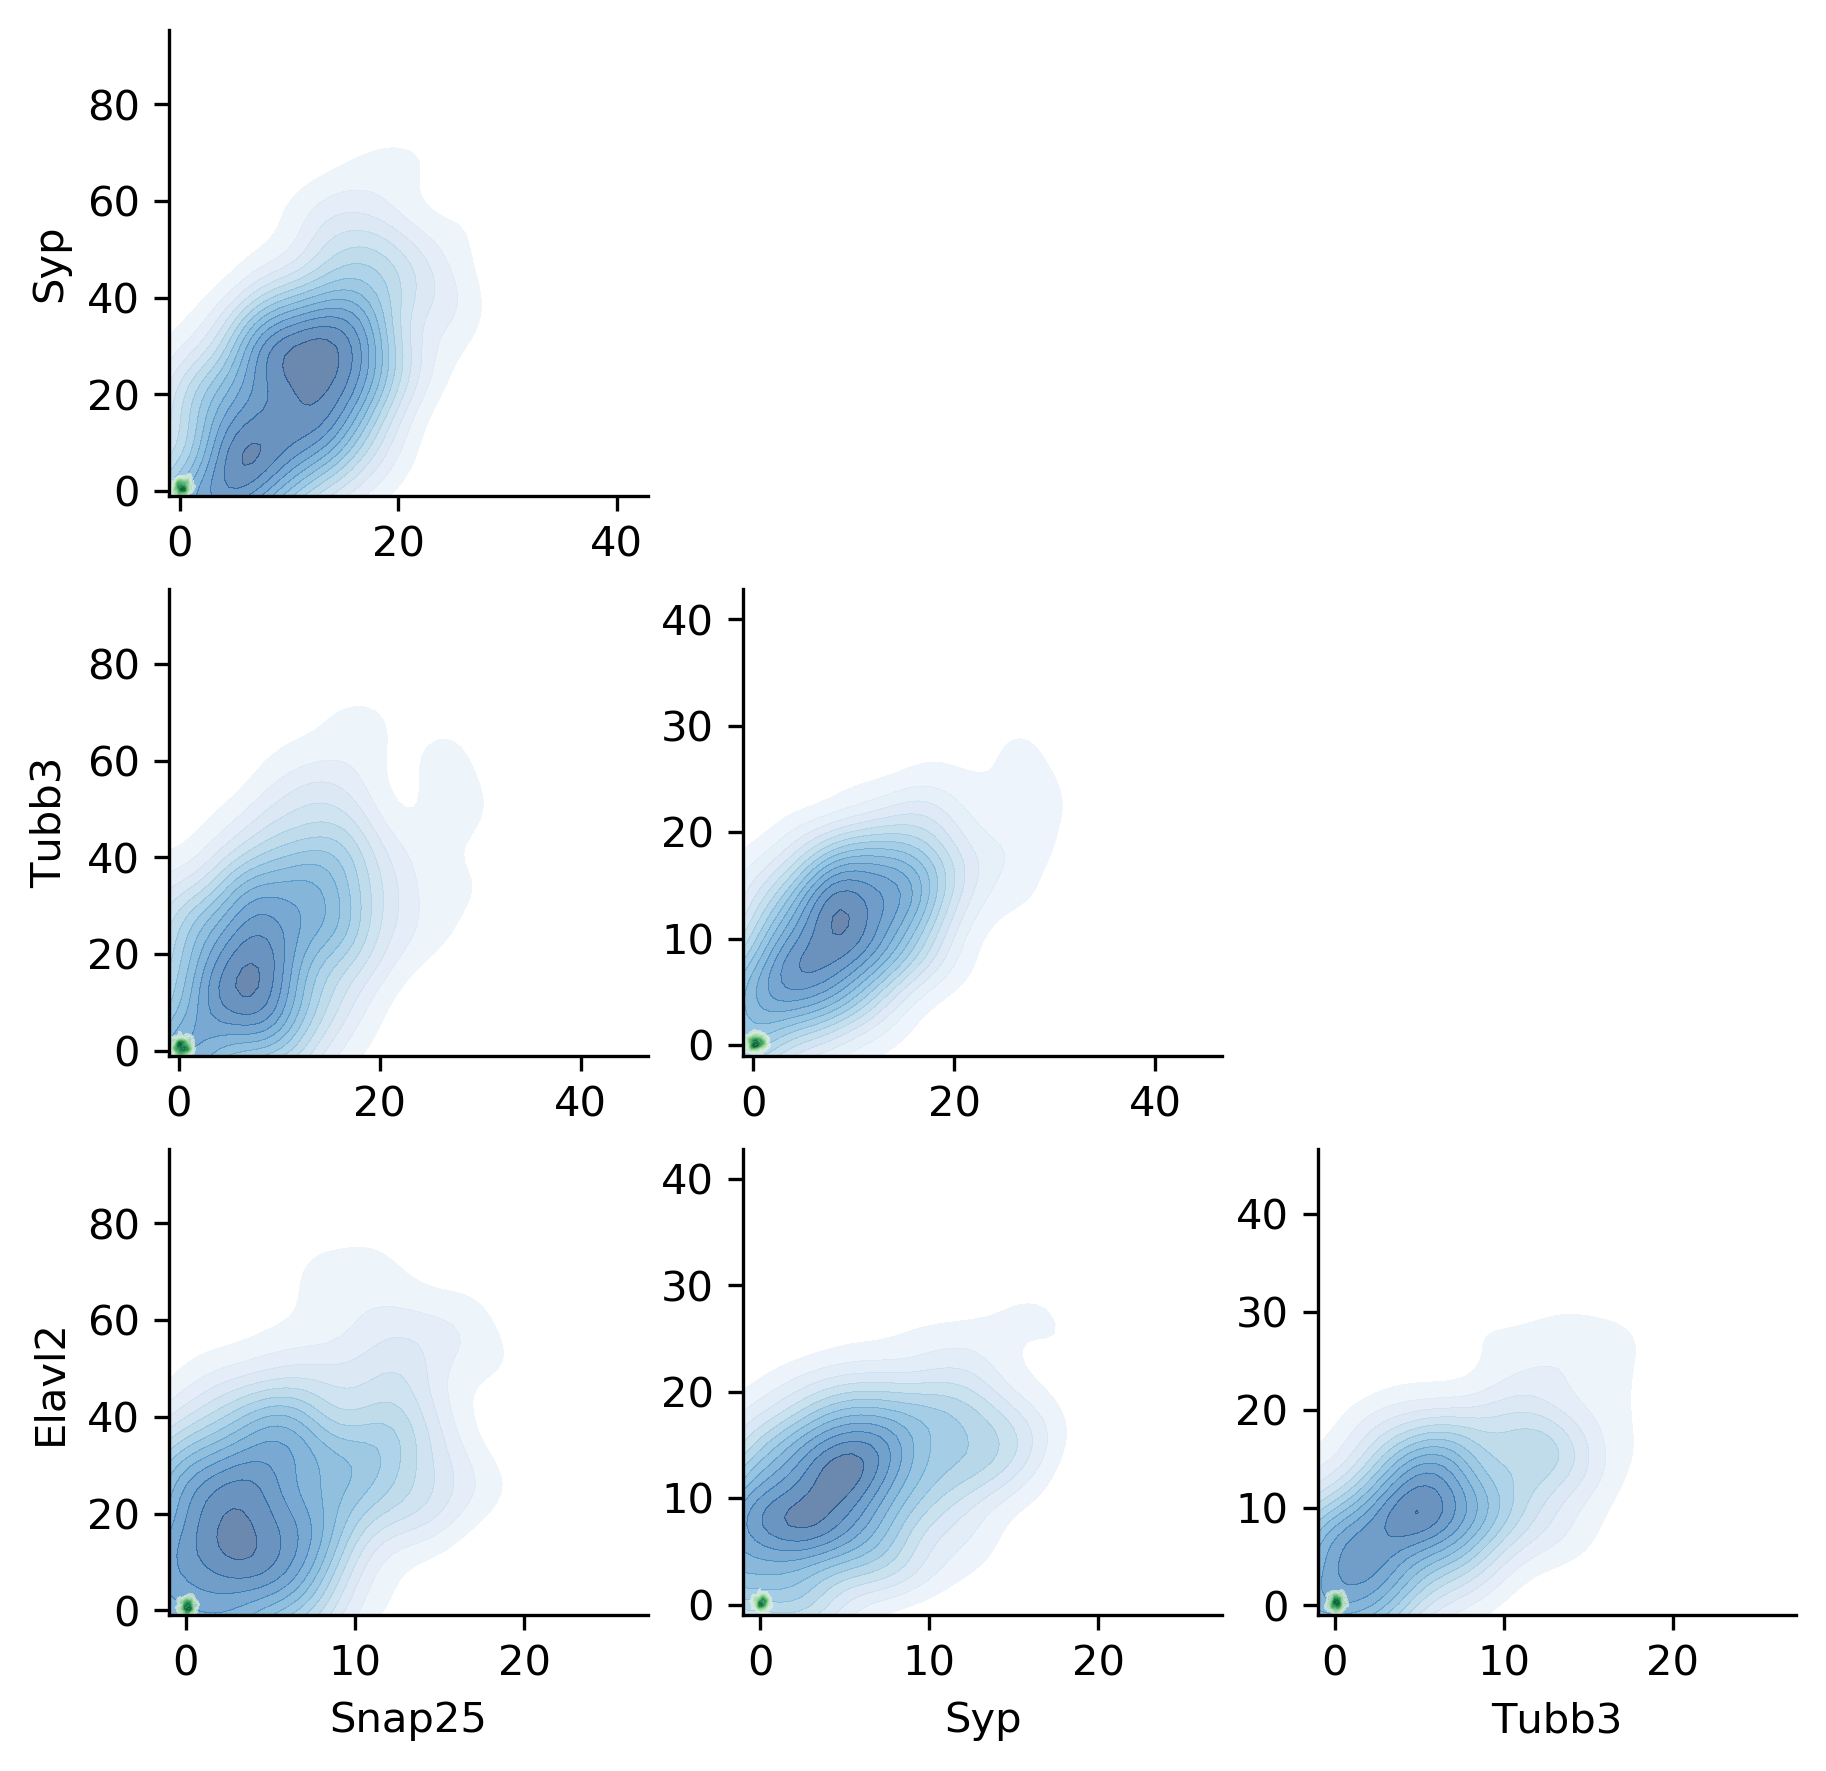

In [307]:
fig, axs = plt.subplots(3, 3, dpi=300, figsize=(7,7))
c1 = mix_data[mix_data.Class.isin(["Neuron"])]
c2 = mix_data[~mix_data.Class.isin(["Neuron"])]
for ax in axs.flat:
    ax.set_axis_off()
for i, j in zip(*np.tril_indices(4, -1)):
    ax = axs[i-1, j]
    ax.set_axis_on()
    params = dict(ax=ax, shade=True, shade_lowest=False, alpha=0.6, levels=14)
    seaborn.kdeplot(c1.iloc[:,i], c1.iloc[:,j], cmap="Blues", **params)
    seaborn.kdeplot(c2.iloc[:,i], c2.iloc[:,j], cmap="Greens", **params)
    ax.set_xlim(-1, ax.get_xlim()[1])
    ax.set_ylim(-1, ax.get_ylim()[1])
    if i < 3:
        ax.set_xlabel("")
    else:
        ax.set_xlabel(mix_data.columns[j])
    if j > 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel(mix_data.columns[i])
    seaborn.despine(fig, ax)

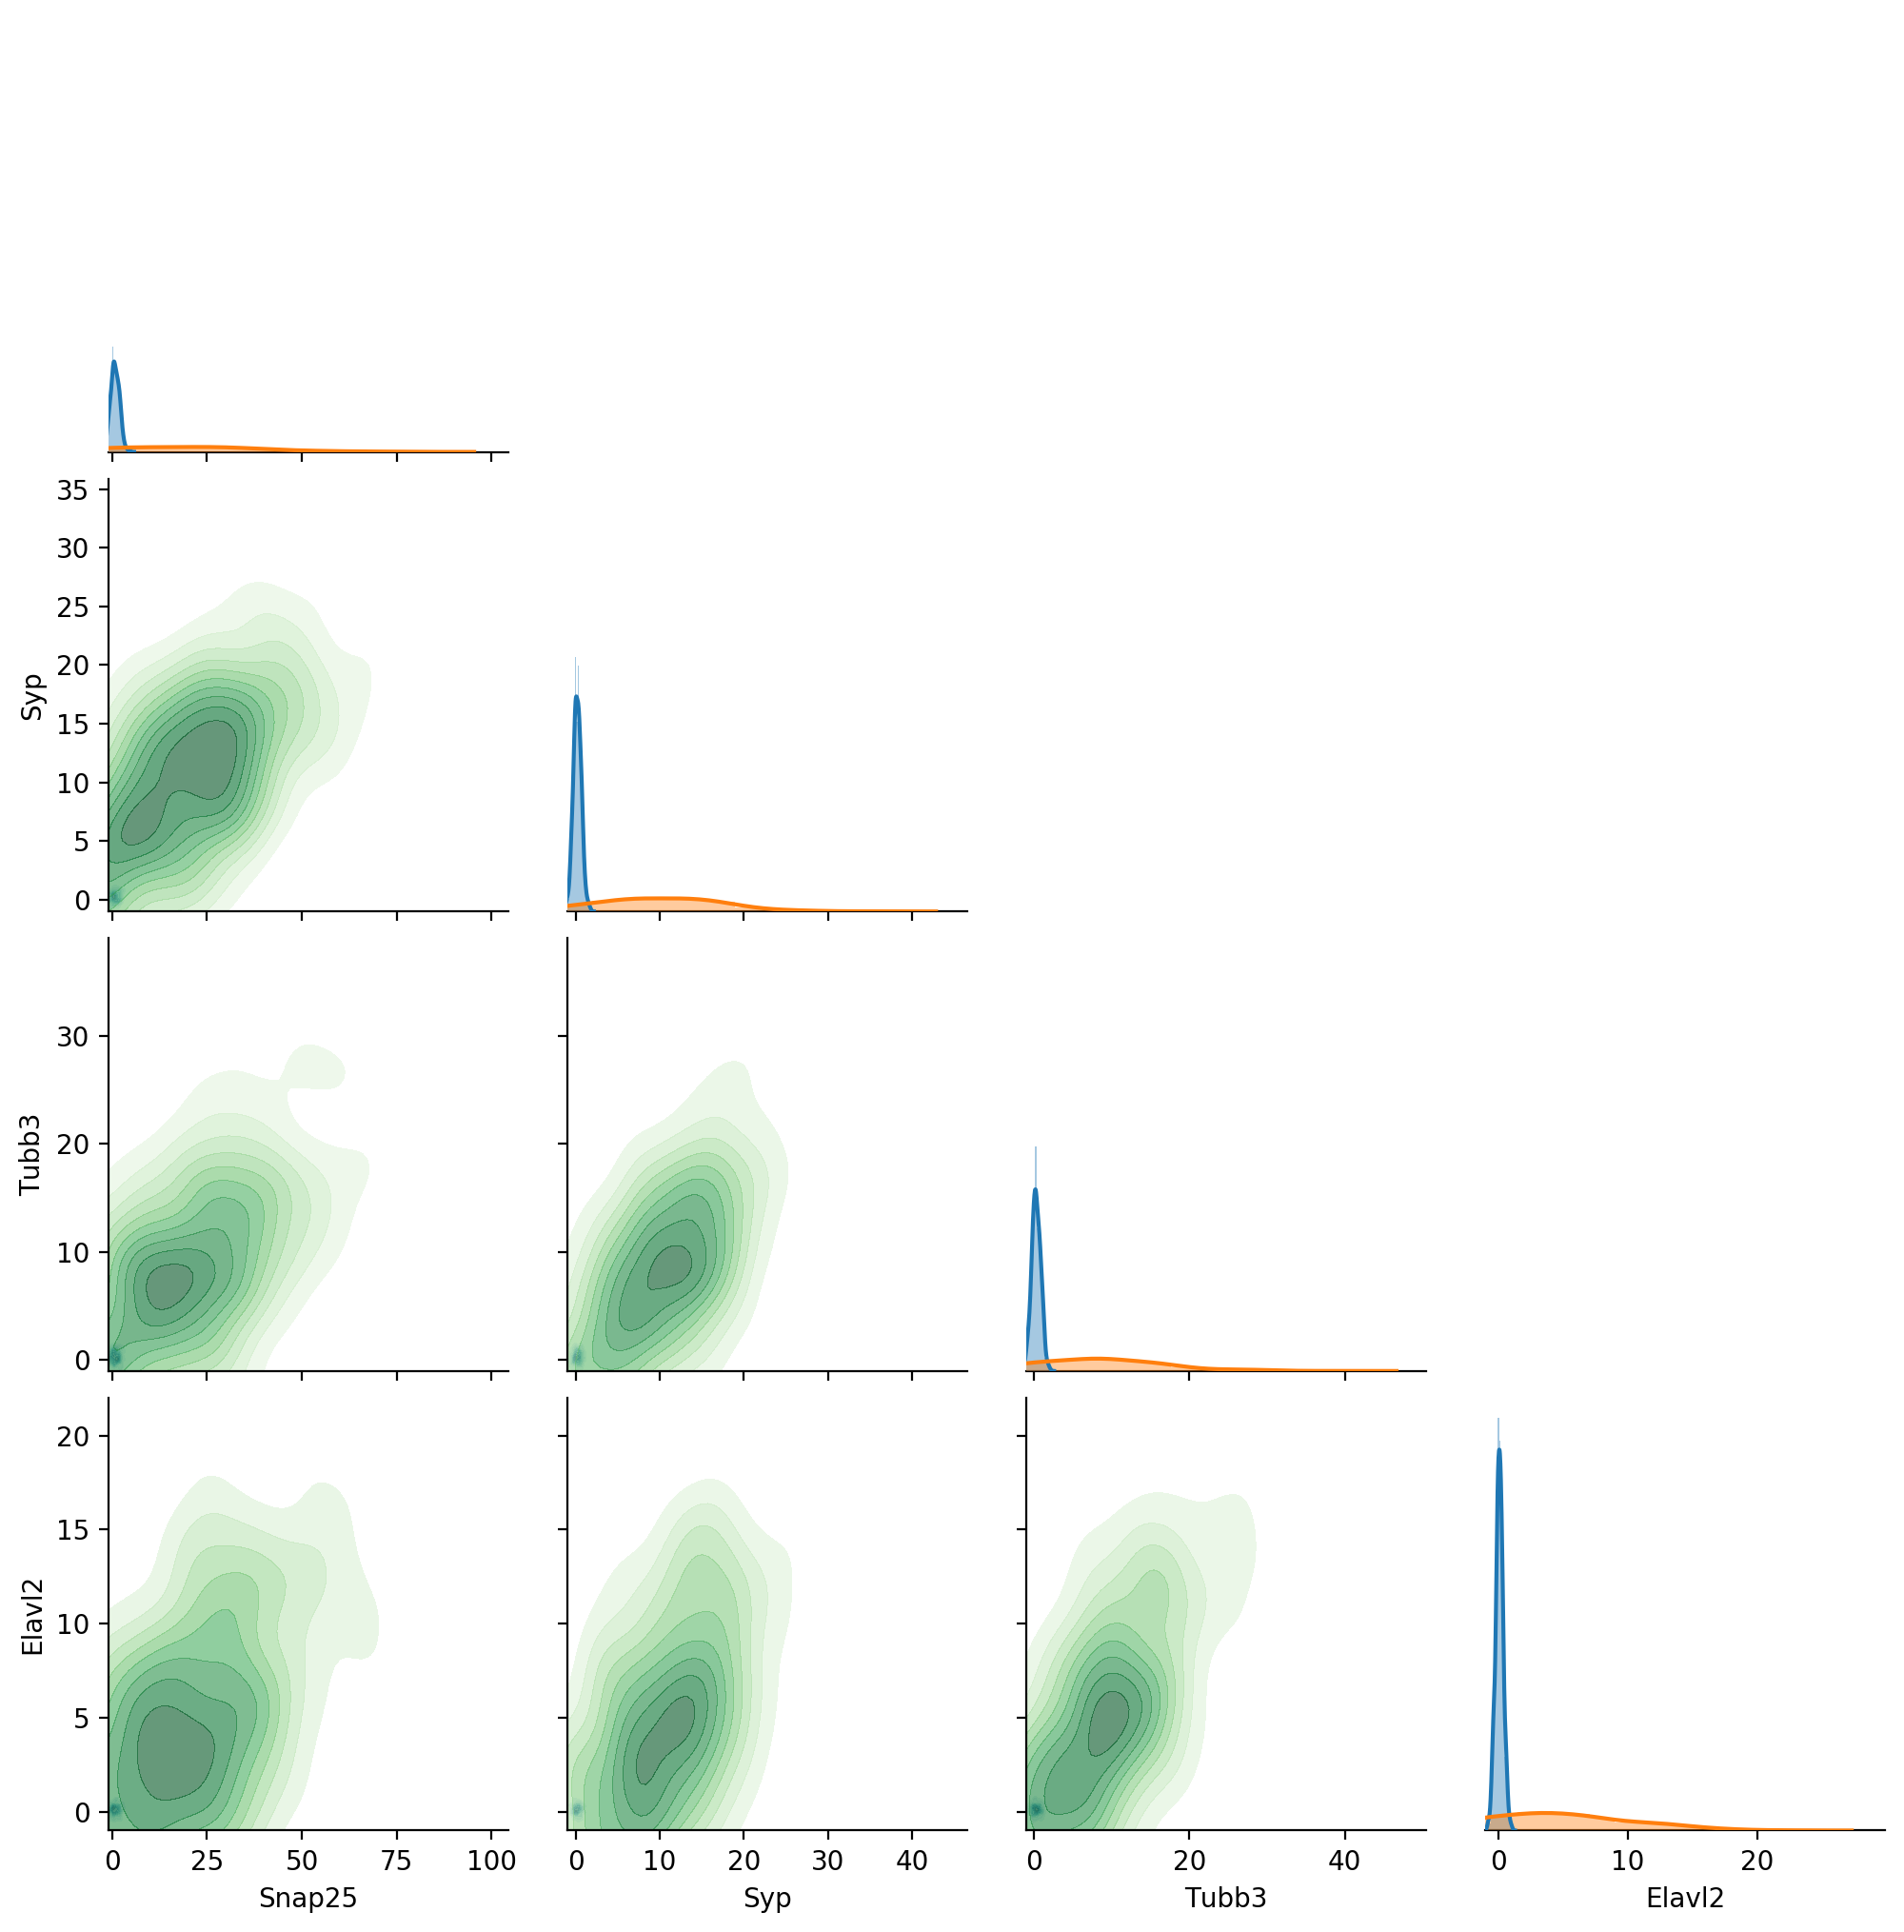

In [282]:
g = seaborn.PairGrid(mix_data, hue="Class", corner=True, hue_kws={"cmap": ["Blues", "Greens"]})
g = g.map_diag(seaborn.distplot, hist_kws={"lw": 2})#, histtype: "stepfilled"})
g = g.map_lower(seaborn.kdeplot, shade=True, shade_lowest=False, alpha=0.6, cut=0)
for ax in g.axes.flat:
    if ax is None: continue
    ax.set_xlim(-1, ax.get_xlim()[1])
    ax.set_ylim(-1, ax.get_ylim()[1])